In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from collections import namedtuple 

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
date = namedtuple('Date', 'month day')

In [3]:
sns.set()

In [51]:
#Функция вычисления центроидов всех кластеров 
def centroids(data, clusters):
    n = np.unique(clusters)
    dist = []
    for i in n:
        matrix = data.values[np.where(clusters == i)]
        dist.append(np.sum(matrix, axis=0) / matrix.shape[0])
    return np.array(dist)

#Расстояние между цетроидами кластеров (на вход матрица цетроидов) 
def cluster_dist(matrix):
    size = matrix.shape[0]
    av_dist = [sum((euclid(matrix[i], matrix[j]) for j in range(i, size))) for i in range(size)]
    return sum(av_dist)/ len(av_dist)

#Функция вычисления среднего расстояния между кластерами  
av_dist = lambda df, cl: cluster_dist(centroids(df, cl))

#Евклидово расстояние
euclid = lambda x, y: np.sqrt(np.sum((x - y)**2))

def plot(*args):
    plt.figure(figsize=(20, 6))
    for arg in args:
        plt.plot(arg.T)
    plt.title('Data Example')
    plt.show()

    
s1 = [pd.datetime(2017, 9, 1), pd.datetime(2018, 9, 1)]
d31 = [pd.datetime(2017, 12, 31), pd.datetime(2018, 12, 31)]
f14 = [pd.datetime(2018, 2, 14), pd.datetime(2019, 2, 14)]
f23 = [pd.datetime(2018, 2, 23), pd.datetime(2019, 2, 23)]
m8 = [pd.datetime(2018, 3, 8), pd.datetime(2019, 3, 8)]
allhol = [s1, d31, f14, f23, m8]
colors = ['b', 'g', 'r', 'm', 'c']    

def plot_clust(data, clusters, lines=100):
    centroid = centroids(data, clusters)
    n = np.unique(clusters)
    plt.figure(figsize=(20, 400))
    for i in n:
        plt.subplot(len(n), 1, i+1)
        plt.title(f'cluster {i}, {clusters[clusters==i].count()} items')
        for j, color in zip(allhol, colors):
            plt.axvline(j[0], c=color, label=j[0])
            plt.axvline(j[1], c=color, label=j[1])
        idx = np.where(clusters == i)[0][:lines]
        plt.plot(data.columns, centroid[i], c='red')
        for j in idx:
            plt.plot(data.T.iloc[:, j], c='black', alpha=0.1)

            
def metrics_values(data, clusters):
    metrics = {'Average Distance': av_dist(data, clusters),
                'Silhouette score': silhouette_score(data, clusters),
                'Calinski-Harabasz score': calinski_harabasz_score(data, clusters),
                'Davies bouldin score': davies_bouldin_score(data, clusters)}
    return metrics
    

In [5]:
df = pd.read_csv(r'st_ts.txt', index_col='id')
df = np.log(1.1 + df[:60000]).T
df.index = pd.DatetimeIndex(df.index)
scale = StandardScaler()
sc_df = pd.DataFrame(scale.fit_transform(df).T, index=df.columns, columns=df.index)

In [6]:
seasons = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'fall': [9, 10, 11]
}

In [7]:
dates = {
    '31d': date(12, 31),
    '1s': date(9, 1),
    '14f': date(2, 14),
    '23f': date(2, 23),
    '8m': date(3, 8)
}

In [8]:
def extract_dates_by_years(df, celeb, year, n_days):
    date = pd.datetime(year=year, month=dates[celeb].month, day=dates[celeb].day)
    sum1 = df[df.index <= date][-n_days:].sum()
    sum2 = df[df.index > date][:n_days].sum()
    return sum1 / sum2
    

In [9]:
# def extract_dates(df, celeb, n_days):
#     years = df.index.year.unique()
#     sum1 = 0
#     sum2 = 0
#     for year in years:
#         date = pd.datetime(year=year, month=dates[celeb].month, day=dates[celeb].day)
#         sum1 += df[df.index <= date][-n_days:].sum().sum()
#         sum2 += df[df.index > date][:n_days].sum().sum()
#         print(year, sum1, sum2)

In [10]:
def extract_seasons(df, season1, season2):
    sum1 = df[df.index.month.isin(seasons[season1])].sum()
    sum2 = df[df.index.month.isin(seasons[season2])].sum()
    return sum1 / sum2

In [11]:
def extract_seasons_by_years(df, year, season1, season2):
    if season1 == 'winter':
        sum1 = df[(df.index.month.isin(seasons[season1]))  & (df.index.year.isin([year, year-1])) & (df.index < f'{year}-03-01')].sum()
        sum2 = df[(df.index.month.isin(seasons[season2]))  & (df.index.year == year)].sum()
        return sum1 / sum2
    if season2 == 'winter':
        sum1 = df[(df.index.month.isin(seasons[season1]))  & (df.index.year == year)].sum()
        sum2 = df[(df.index.month.isin(seasons[season2]))  & (df.index.year.isin([year, year-1])) & (df.index < f'{year}-03-01')].sum()
        return sum1 / sum2
    sum1 = df[(df.index.month.isin(seasons[season1]))  & (df.index.year == year)].sum()
    sum2 = df[(df.index.month.isin(seasons[season2]))  & (df.index.year == year)].sum()
    return sum1 / sum2

In [78]:
day_feat = [extract_seasons(df, 'winter', 'summer'), extract_seasons(df, 'winter', 'spring'),
            extract_seasons(df, 'winter', 'fall'),
            extract_seasons(df, 'summer', 'spring'), extract_seasons(df, 'summer', 'fall'),
            extract_seasons(df, 'fall', 'spring'),
           extract_dates_by_years(df, '31d', 2017, 2), extract_dates_by_years(df, '31d', 2018, 2),
            extract_dates_by_years(df, '31d', 2018, 3), extract_dates_by_years(df, '31d', 2018, 4),
           extract_dates_by_years(df, '1s', 2017, 1), extract_dates_by_years(df, '1s', 2018, 2),
            extract_dates_by_years(df, '1s', 2018, 3), extract_dates_by_years(df, '1s', 2018, 4),
           extract_dates_by_years(df, '14f', 2018, 1), extract_dates_by_years(df, '14f', 2019, 1),
           extract_dates_by_years(df, '23f', 2018, 1), extract_dates_by_years(df, '23f', 2019, 1),
           extract_dates_by_years(df, '8m', 2018, 1), extract_dates_by_years(df, '8m', 2019, 1)]



In [79]:
df_dates = pd.DataFrame(day_feat).T
df_dates = pd.DataFrame(scale.fit_transform(df_dates), index=sc_df.index)

12    8744
13    7190
9     2922
16    2367
22    2305
10    2285
7     2196
1     2084
33    1991
8     1977
6     1851
28    1827
30    1812
11    1792
2     1546
3     1447
27    1278
36    1264
23    1145
4      884
31     877
15     816
35     785
0      775
26     721
20     636
39     635
37     634
21     628
25     613
5      612
34     592
38     524
14     511
19     486
29     486
32     473
17     109
18      98
24      82
dtype: int64


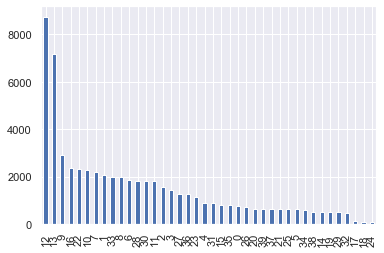

CPU times: user 603 ms, sys: 105 ms, total: 708 ms
Wall time: 19 s


In [80]:
%%time
clusters = pd.Series(KMeans(n_clusters=40, random_state=42, n_jobs = -1).fit_predict(df_dates), index = sc_df.index)

print(clusters.value_counts())
clusters.value_counts().plot.bar()
plt.show()

CPU times: user 1.64 s, sys: 53.4 ms, total: 1.69 s
Wall time: 1.78 s


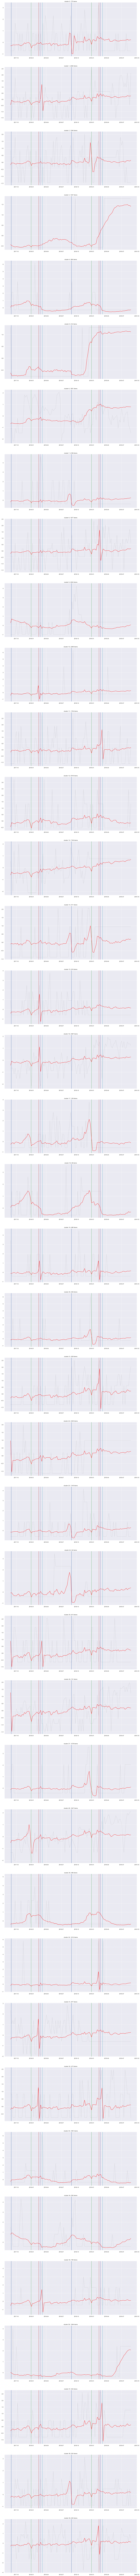

In [81]:
%%time
plot_clust(sc_df, clusters, 1)

In [82]:
print(metrics_values(sc_df, clusters))

{'Average Distance': 83.79056020435792, 'Silhouette score': -0.06821863736323079, 'Calinski-Harabasz score': 129.1862491256796, 'Davies bouldin score': 13.52004916712653}


[extract_seasons(df, 'winter', 'summer'), extract_seasons(df, 'spring', 'fall'),
           extract_dates_by_years(df, '31d', 2017, 2), extract_dates_by_years(df, '31d', 2018, 2),
           extract_dates_by_years(df, '1s', 2017, 1), extract_dates_by_years(df, '1s', 2018, 2),
           extract_dates_by_years(df, '14f', 2018, 1), extract_dates_by_years(df, '14f', 2019, 1),
           extract_dates_by_years(df, '23f', 2018, 1), extract_dates_by_years(df, '23f', 2019, 1),
           extract_dates_by_years(df, '8m', 2018, 1), extract_dates_by_years(df, '8m', 2019, 1)]

{'Average Distance': 72.22835584960009, 'Silhouette score': -0.02343601589427289, 'Calinski-Harabasz score': 97.87853591384892, 'Davies bouldin score': 13.9944072479652}


[extract_seasons(df, 'winter', 'summer'), extract_seasons(df, 'spring', 'fall'),
           extract_dates_by_years(df, '31d', 2017, 2), extract_dates_by_years(df, '31d', 2018, 2),
           extract_dates_by_years(df, '1s', 2017, 1), extract_dates_by_years(df, '1s', 2018, 2),
           extract_dates_by_years(df, '14f', 2018, 1), extract_dates_by_years(df, '14f', 2019, 1),
           extract_dates_by_years(df, '23f', 2018, 1), extract_dates_by_years(df, '23f', 2019, 1),
           extract_dates_by_years(df, '8m', 2018, 1), extract_dates_by_years(df, '8m', 2019, 1)]
           
{'Average Distance': 73.77178176570125, 'Silhouette score': -0.05710626730958523, 'Calinski-Harabasz score': 102.60883251174322, 'Davies bouldin score': 15.303550155635786}

[extract_seasons(df, 'winter', 'summer'), extract_seasons(df, 'winter', 'spring'),
            extract_seasons(df, 'winter', 'fall'), extract_seasons(df, 'summer', 'winter'),
            extract_seasons(df, 'summer', 'spring'), extract_seasons(df, 'summer', 'fall'),
            extract_seasons(df, 'fall', 'winter'), extract_seasons(df, 'fall', 'spring'),
            extract_seasons(df, 'fall', 'summer'), extract_seasons(df, 'spring', 'summer'),
            extract_seasons(df, 'spring', 'fall'), extract_seasons(df, 'spring', 'winter'),
           extract_dates_by_years(df, '31d', 2017, 2), extract_dates_by_years(df, '31d', 2018, 2),
           extract_dates_by_years(df, '1s', 2017, 1), extract_dates_by_years(df, '1s', 2018, 2),
           extract_dates_by_years(df, '14f', 2018, 1), extract_dates_by_years(df, '14f', 2019, 1),
           extract_dates_by_years(df, '23f', 2018, 1), extract_dates_by_years(df, '23f', 2019, 1),
           extract_dates_by_years(df, '8m', 2018, 1), extract_dates_by_years(df, '8m', 2019, 1)]

{'Average Distance': 98.73627229456469, 'Silhouette score': -0.06483746600339244, 'Calinski-Harabasz score': 165.83622340623955, 'Davies bouldin score': 9.630686690299086}

[extract_seasons(df, 'winter', 'summer'), extract_seasons(df, 'winter', 'spring'),
            extract_seasons(df, 'winter', 'fall'),
            extract_seasons(df, 'summer', 'spring'), extract_seasons(df, 'summer', 'fall'),
            extract_seasons(df, 'fall', 'spring'),
           extract_dates_by_years(df, '31d', 2017, 2), extract_dates_by_years(df, '31d', 2018, 2),
           extract_dates_by_years(df, '1s', 2017, 1), extract_dates_by_years(df, '1s', 2018, 2),
           extract_dates_by_years(df, '14f', 2018, 1), extract_dates_by_years(df, '14f', 2019, 1),
           extract_dates_by_years(df, '23f', 2018, 1), extract_dates_by_years(df, '23f', 2019, 1),
           extract_dates_by_years(df, '8m', 2018, 1), extract_dates_by_years(df, '8m', 2019, 1)]

{'Average Distance': 86.0532010737523, 'Silhouette score': -0.06700618818137627, 'Calinski-Harabasz score': 138.08098796118625, 'Davies bouldin score': 12.894700876294323}

[extract_seasons(df, 'winter', 'summer'), extract_seasons(df, 'winter', 'spring'),
            extract_seasons(df, 'winter', 'fall'),
            extract_seasons(df, 'summer', 'spring'), extract_seasons(df, 'summer', 'fall'),
            extract_seasons(df, 'fall', 'spring'),
           extract_dates_by_years(df, '31d', 2017, 2), extract_dates_by_years(df, '31d', 2018, 2),
            extract_dates_by_years(df, '31d', 2018, 3), extract_dates_by_years(df, '31d', 2018, 4),
           extract_dates_by_years(df, '1s', 2017, 1), extract_dates_by_years(df, '1s', 2018, 2),
            extract_dates_by_years(df, '1s', 2018, 3), extract_dates_by_years(df, '1s', 2018, 4),
           extract_dates_by_years(df, '14f', 2018, 1), extract_dates_by_years(df, '14f', 2019, 1),
           extract_dates_by_years(df, '23f', 2018, 1), extract_dates_by_years(df, '23f', 2019, 1),
           extract_dates_by_years(df, '8m', 2018, 1), extract_dates_by_years(df, '8m', 2019, 1)]

